In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
import pandas as pd

 captum (see https://github.com/pytorch/captum).


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
adata = sc.read_10x_mtx('./RNA_data/')
df = pd.read_csv('./RNA_data/df_cell.csv',index_col = 0)
adata.obs['treament'] = df.cell_type
adata.layers["counts"] = adata.X.copy()  # preserve counts
adata

AnnData object with n_obs × n_vars = 5952 × 25178
    obs: 'treament'
    var: 'gene_ids'
    layers: 'counts'

In [5]:
# adata = sc.read('pbmc_tutorial.h5ad')
# adata.X = adata.layers["counts"].copy()

In [6]:
# url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
# output = 'reactome.gmt'
# gdown.download(url, output, quiet=False)

In [7]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
#     batch_key="batch",
    subset=True)

In [11]:
select_terms = adata.varm['I'].sum(0)>12

In [12]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [13]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [14]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [15]:
adata.X = adata.layers["counts"].copy()

In [16]:
# intr_cvae = sca.models.EXPIMAP(
#     adata=adata,
#     condition_key='study',
#     hidden_layer_sizes=[256, 256, 256],
#     recon_loss='nb'
# )

In [17]:
adata.var_names

Index(['UBE2J2', 'NADK', 'GNB1', 'PANK4', 'RPL22', 'UTS2', 'ENO1', 'SLC2A7',
       'DFFA', 'MASP2',
       ...
       'ATP11C', 'IDS', 'CETN2', 'BCAP31', 'IDH3G', 'L1CAM', 'ARHGAP4',
       'IRAK1', 'G6PD', 'TMLHE'],
      dtype='object', length=1975)

In [18]:
adata.obs['condition']='A549'

In [19]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='condition',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1975 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 271
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  271 0 0 1 1975
	with hard mask.
Last Decoder layer: softmax


In [20]:
ALPHA = 0.7

In [21]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2024,
)

Preparing (5952, 1975)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |█████---------------| 25.8%  - epoch_loss: 832.7769920712 - epoch_recon_loss: 817.3548787435 - epoch_kl_loss: 30.8442236128 - val_loss: 784.6214477539 - val_recon_loss: 770.5306640625 - val_kl_loss: 28.18160285953580
ADJUSTED LR
 |██████--------------| 30.5%  - epoch_loss: 828.5852021717 - epoch_recon_loss: 813.3825828916 - epoch_kl_loss: 30.4052332015 - val_loss: 783.1175781250 - val_recon_loss: 769.2314208984 - val_kl_loss: 27.7723163605
ADJUSTED LR
 |███████-------------| 38.0%  - epoch_loss: 836.7019973028 - epoch_recon_loss: 821.5427580334 - epoch_kl_loss: 30.3184873944 - val_loss: 779.2680541992 - val_recon_loss: 765.3648315430 - val_kl_loss: 27.8064640045
ADJUSTED LR
 |████████------------| 41.2%  - epoch_loss: 837.9512096587 - epoch_recon_loss: 822.7752641950 - epoch_kl_loss: 30.3518962860 - val_loss: 784.4515991211 - val_recon_loss: 770.5815185547 - val_kl_loss: 27.7401523

In [22]:
intr_cvae.save('expiMap_A549')

In [23]:
MEAN = False

In [24]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [25]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [26]:
sc.tl.umap(adata)

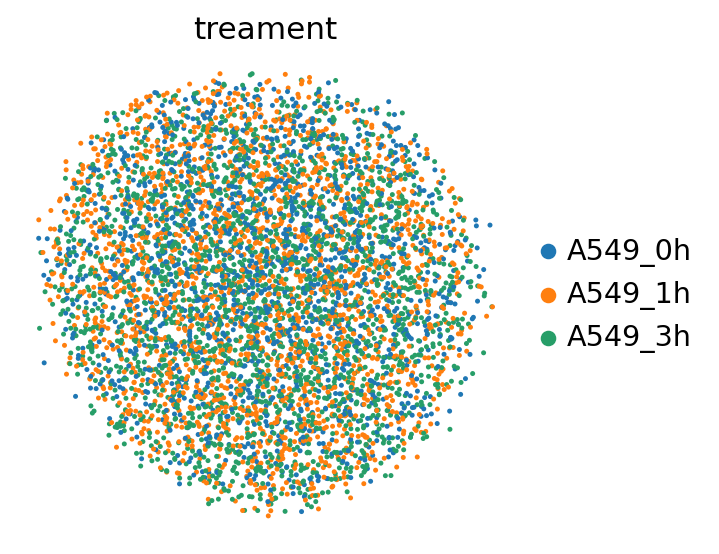

In [27]:
sc.pl.umap(adata, color=['treament'], frameon=False)

In [28]:
adata.obsm['X_cvae'].shape

(5952, 214)

In [29]:
adata.write_h5ad('./expiMap/adata_expiMap.h5ad')

In [62]:
cell_scores = adata.obsm['X_cvae']
cell_scores.shape

(5952, 214)

In [50]:
intr_cvae.update_terms(adata=adata)

In [53]:
intr_cvae.latent_directions(adata=adata)

In [61]:
np.sum(adata.uns['directions']==0)

57

In [64]:
214 + 57

271

In [73]:
idx = adata.uns['directions'] != 0
gene_set_name = np.array(adata.uns['terms'])

In [75]:
gene_score_df = pd.DataFrame(cell_scores, 
                             index=adata.obs_names, 
                             columns=gene_set_name[idx.tolist()])

In [76]:
gene_score_df

,TRANSLATION,PYRUVATE_METABOLISM_AND_CITRIC,FORMATION_OF_THE_TERNARY_COMPL,SIGNALING_BY_RHO_GTPASES,SIGNALING_BY_WNT,SIGNALLING_BY_NGF,SIGNALING_BY_SCF_KIT,DEVELOPMENTAL_BIOLOGY,TCA_CYCLE_AND_RESPIRATORY_ELEC,ANTIGEN_PROCESSING_CROSS_PRESE,...,NONSENSE_MEDIATED_DECAY_ENHANC,ANTIGEN_PROCESSING_UBIQUITINAT,TELOMERE_MAINTENANCE,PLATELET_ACTIVATION_SIGNALING_,G2_M_CHECKPOINTS,S_PHASE,SCFSKP2_MEDIATED_DEGRADATION_O,VIF_MEDIATED_DEGRADATION_OF_AP,SIGNALING_BY_FGFR,PI3K_CASCADE
sci-RNA-A-001.AAGTACGTTA,-1.132258,1.185260,0.289265,-0.904959,0.713365,0.193018,-0.506686,0.929495,0.263995,0.131643,...,-0.034531,1.482261,-0.529212,1.628664,0.057207,1.728290,0.814200,1.604696,-1.645199,1.435673
sci-RNA-A-001.TCTCTCATCC,1.714699,1.207925,1.217072,0.991573,-1.025341,-2.015187,0.255908,1.370887,-0.278194,0.167699,...,0.284675,-0.951784,0.891975,0.234019,-0.426401,1.039109,0.458016,-0.396936,1.741477,-0.673369
sci-RNA-A-001.TCCGCCGGTC,1.428496,-0.564398,-0.489933,0.182794,-0.433509,-0.200444,-1.053426,0.564002,1.455796,-1.605552,...,-0.316859,-2.453622,0.177033,1.194013,-0.537831,1.381086,0.052741,1.012188,-0.542897,1.482861
sci-RNA-A-001.TTCTATAGAG,-1.132549,-2.537810,2.199112,0.856360,0.774229,2.341728,-0.596320,0.812272,1.163029,0.819137,...,0.369972,0.803591,-0.505744,-0.866748,0.972851,0.900432,-1.733306,-0.531280,0.012625,-0.516972
sci-RNA-A-001.CGTCTATGAA,1.249623,0.836249,-0.020582,0.741428,-1.087689,-2.612187,-0.373569,0.630380,-2.102852,0.412925,...,0.338445,0.321184,-2.938358,1.291584,-0.672680,1.881770,0.575238,0.386821,-0.167467,-3.251857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
co-RNA-only-192.GGCTGCCTTA,1.906297,-0.246461,0.909376,0.141230,-0.063554,1.770651,-0.201098,0.094017,-1.082210,1.161932,...,0.286274,1.657917,-0.364393,-0.575153,0.174805,-0.884559,0.717305,0.592531,2.274203,0.967086
co-RNA-only-192.TTCTCTACTA,0.757410,-0.517970,-0.006795,-1.033937,-0.030341,-1.840970,0.957593,1.418030,0.372323,0.214762,...,-0.900768,-1.818445,1.827402,-1.850912,-0.130900,1.073662,0.796655,-0.258750,2.411091,0.588586
co-RNA-only-192.TTGCAGCATT,-1.181745,0.312301,0.736867,-1.526639,0.929787,0.994110,0.626924,1.625821,0.134902,0.710036,...,0.595813,-0.990085,0.031120,-1.658908,0.434155,1.044042,-0.185882,-0.340270,-0.590156,0.366105
co-RNA-only-192.TCCTCTCCGT,1.288162,-0.153258,0.449930,-0.329218,1.275180,0.750775,-1.534576,-0.429842,0.034050,0.463809,...,-0.825319,1.026806,-0.771038,0.816624,0.433997,-2.213108,-1.171734,-1.167202,0.583116,1.401293


In [77]:
gene_score_df.to_csv('./expiMap/df_gene_score.csv')

# Evaluation

In [1]:
library(Seurat)
library(tidyverse)
library(cowplot)
library(DropletUtils)
library(clustree)

Loading required package: SeuratObject

Loading required package: sp

'SeuratObject' was built under R 4.3.0 but the current version is
4.3.2; it is recomended that you reinstall 'SeuratObject' as the ABI
for R may have changed

'SeuratObject' was built with package 'Matrix' 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) t

In [2]:
input_matrix = read.csv('./expiMap/df_gene_score.csv',row.names=1)
metadata<-readRDS('metadata.rds')
table(rownames(input_matrix) == rownames(metadata))


TRUE 
5952 

In [3]:
seurat_obj <- Seurat::CreateSeuratObject(counts = t(input_matrix))
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, metadata[,4,drop=FALSE])
seurat_obj@assays$RNA$data = seurat_obj@assays$RNA$counts
seurat_obj@assays$RNA$scale.data = as.matrix(seurat_obj@assays$RNA$counts)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


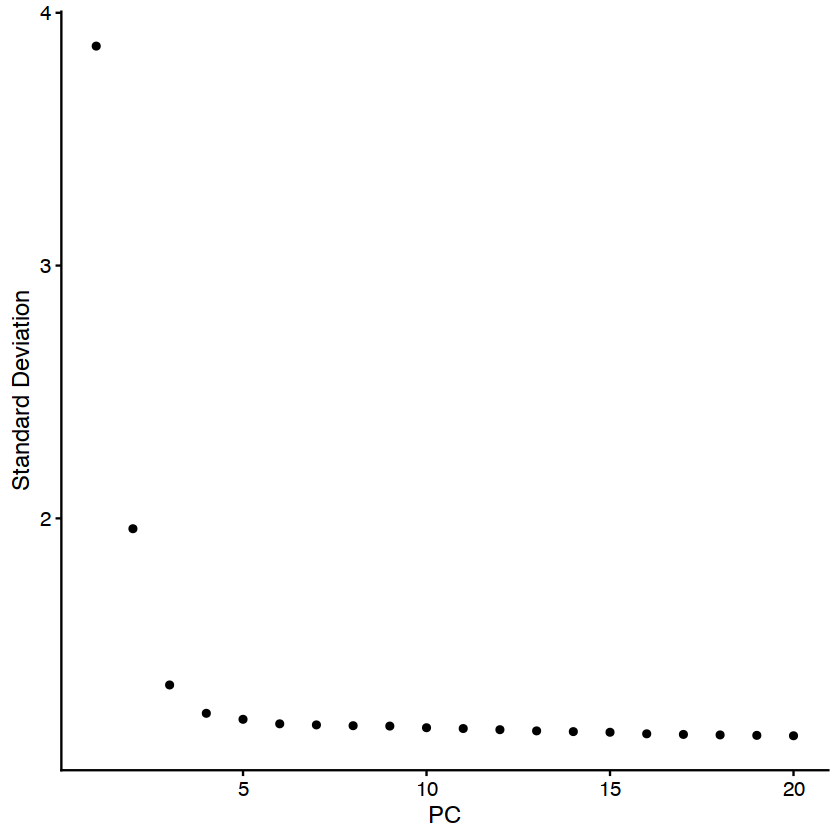

In [4]:
seurat_obj <- Seurat::RunPCA(object = seurat_obj, features = rownames(seurat_obj), seed.use = 1, verbose=FALSE)
ElbowPlot(seurat_obj)

Warning message in Seurat::JackStraw(seurat_obj, num.replicate = 10, dims = 30):
"Number of variable genes given 0.01 as the prop.freq is low. Consider including more variable genes and/or increasing prop.freq. Continuing with 3 genes in every random sampling."
Warning message:
"Removed 5825 rows containing missing values (`geom_point()`)."


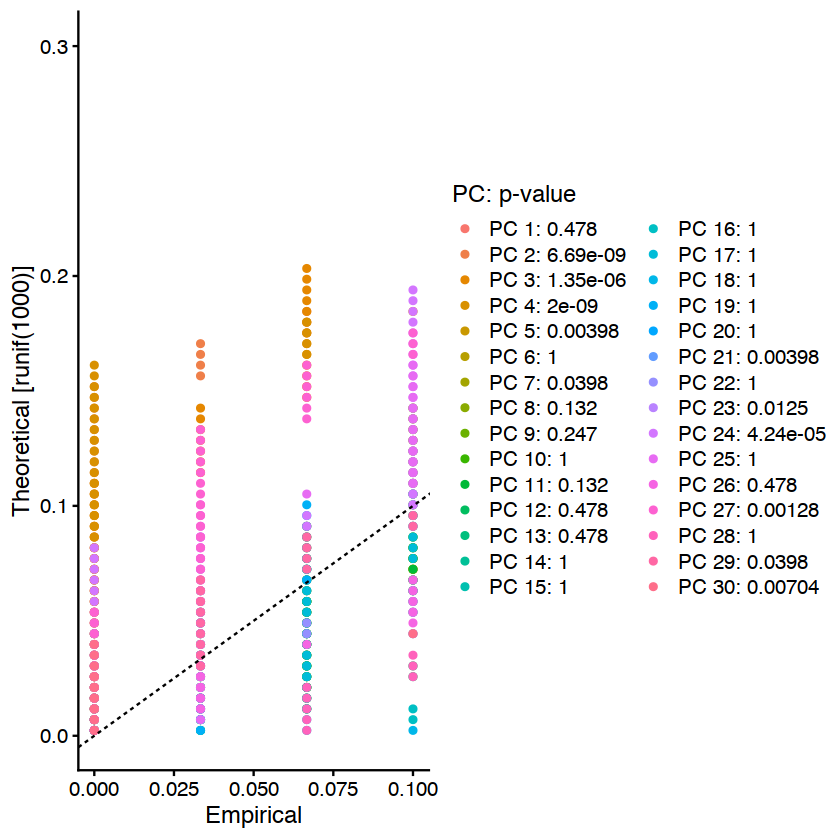

In [5]:
# perform JackStaw procedure and identify 'significant' PCs as those who have a strong enrichment of low p-value features. (https://satijalab.org/seurat/articles/pbmc3k_tutorial.html)
seurat_obj <- Seurat::JackStraw(seurat_obj, num.replicate = 10,dims = 30)
seurat_obj <- Seurat::ScoreJackStraw(seurat_obj, dims = 1:30)
Seurat::JackStrawPlot(seurat_obj, dims = 1:30)

12:46:25 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:46:25 Read 5952 rows and found 10 numeric columns

12:46:25 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:46:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*


*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:46:26 Writing NN index file to temp file /var/folders/yq/wgt5tq6d7q7d6l08jg46y37ntzjz8q/T//Rtmp3LmtX9/file53cf41ecc3d

12:46:26 Searching Annoy index using 1 thread, search_k = 3000

12:46:28 Annoy recall = 100%

12:46:28 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

12:46:29 Initializing from normalized Laplacian + noise (using RSpectra)

12:46:29 Commencing optimization for 500 epochs, with 234932 positive edges

12:46:37 Optimization finished



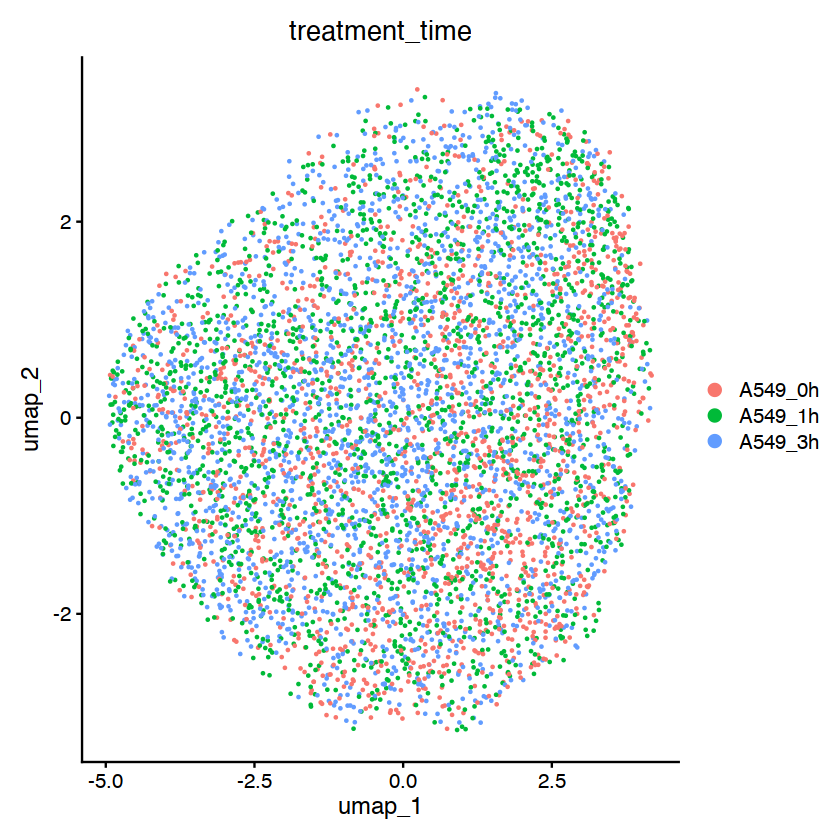

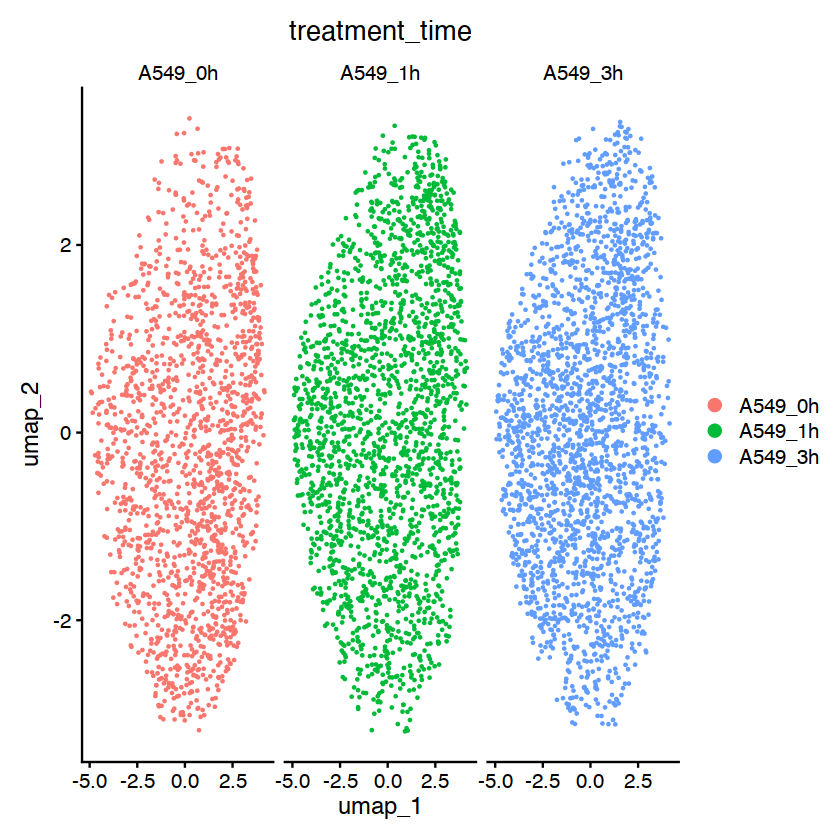

In [8]:
seurat_obj <- RunUMAP(seurat_obj, dims = 1:10)
DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment_time')
DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment_time',split.by = 'treatment_time')

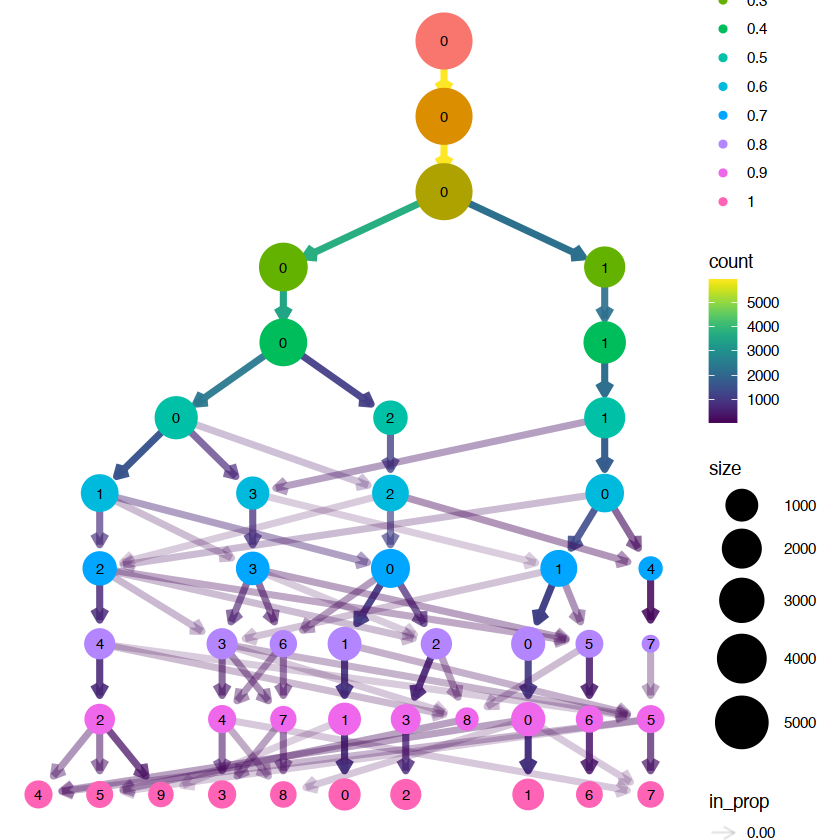

In [9]:
cluster_resolution <- seq(0,1,0.1)
n_pc = 10

seurat_obj <- Seurat::FindNeighbors(seurat_obj, reduction = "pca",  dims = 1:n_pc, verbose = FALSE)

for (resolution in cluster_resolution) {
  seurat_obj <- Seurat::FindClusters(seurat_obj, resolution = resolution, verbose = FALSE)
}

clustree::clustree(seurat_obj, prefix = "RNA_snn_res.")

In [10]:
p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'RNA_snn_res.0.8') + labs(title = '')
cowplot::save_plot('./expiMap/UAMP_cluster.png', p,
                   base_aspect_ratio = 1, base_height = 4)

seurat_obj$treatment <- substring(seurat_obj$treatment_time,6)

p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment') + labs(title = 'Treatment')
cowplot::save_plot('./expiMap/UAMP_treatment_time.png', p,
                   base_aspect_ratio = 1, base_height = 4)

In [17]:
saveRDS(seurat_obj,'./expiMap/Seurat.rds')

In [6]:
aricode::ARI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.7)
aricode::AMI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.7)

[1] 0.003994848

[1] 0.0032094

In [7]:
aricode::ARI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.8)
aricode::AMI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.8)

[1] 0.005786665

[1] 0.006594674

In [9]:
aricode::ARI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.1)
aricode::AMI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.1)

[1] 0.003959943

[1] 0.005395827